In [1]:
#setup torch and device:
import torch
import torchvision
import torchmetrics
import torch.nn as nn
import numpy as np
from sklearn.datasets import load_sample_images

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

sample_images = np.stack(load_sample_images()["images"])
sample_images = torch.tensor(sample_images, dtype=torch.float32) / 255
sample_images_permuted = sample_images.permute(0, 3, 1, 2)
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):    
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    model.eval()
    return history

device

'cuda'

Eftersom neurala nätverk är både svåra och dyra att träna så vill vi kunna återanvända existerande modeller på något allmänt sätt. Idéen kallad <em>transfer learning</em> går ut på att "frysa" delar av nätverket och sedan träna om bara delar av det. Alternativt att ersätta delar av en existerande modell med nya lager och träna bara just de lagrena på en mindre datamängd.

In [2]:
# Ladda ner vikterna för convnext tränad på ImageNet
weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
# instantiera ett convnext lager med vikterna ovan
model = torchvision.models.convnext_base(weights=weights).to(device)

In [3]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [4]:
list(torchvision.models.get_model_weights("convnext_base"))

[ConvNeXt_Base_Weights.IMAGENET1K_V1]

In [5]:
for mod in torchvision.models.list_models():
    print(list(torchvision.models.get_model_weights(mod)))

[AlexNet_Weights.IMAGENET1K_V1]
[ConvNeXt_Base_Weights.IMAGENET1K_V1]
[ConvNeXt_Large_Weights.IMAGENET1K_V1]
[ConvNeXt_Small_Weights.IMAGENET1K_V1]
[ConvNeXt_Tiny_Weights.IMAGENET1K_V1]
[DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1]
[DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1]
[DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1]
[DenseNet121_Weights.IMAGENET1K_V1]
[DenseNet161_Weights.IMAGENET1K_V1]
[DenseNet169_Weights.IMAGENET1K_V1]
[DenseNet201_Weights.IMAGENET1K_V1]
[EfficientNet_B0_Weights.IMAGENET1K_V1]
[EfficientNet_B1_Weights.IMAGENET1K_V1, EfficientNet_B1_Weights.IMAGENET1K_V2]
[EfficientNet_B2_Weights.IMAGENET1K_V1]
[EfficientNet_B3_Weights.IMAGENET1K_V1]
[EfficientNet_B4_Weights.IMAGENET1K_V1]
[EfficientNet_B5_Weights.IMAGENET1K_V1]
[EfficientNet_B6_Weights.IMAGENET1K_V1]
[EfficientNet_B7_Weights.IMAGENET1K_V1]
[EfficientNet_V2_L_Weights.IMAGENET1K_V1]
[EfficientNet_V2_M_Weights.IMAGENET1K_V1]
[EfficientNet_V2_S_Weights.IMAGENET1K_V1]
[FasterRCNN_Mob

Istället för att på egenhand formattera indatan så att den matchar vad nätverket förväntar sig så tillhandahåller de flesta modeller något sätt att använda dess transform-funktioner. Pytorch modeller har en <code>transforms()</code> metod.

In [6]:
transforms = weights.transforms()
preprocessed_images = transforms(sample_images_permuted)

Klassificera bilderna (pagodan och dahlian):

In [7]:
model.eval()
with torch.no_grad():
    y_logits = model(preprocessed_images.to(device))
y_pred = torch.argmax(y_logits, dim=1)
y_pred

tensor([698, 985], device='cuda:0')

Ok, så vilka klasser är '698' och '985'?

In [8]:
class_names = weights.meta["categories"]
[class_names[class_id] for class_id in y_pred]

['palace', 'daisy']

'Pagoda' klassificerades som ett "palats" medans 'dahlia' klassificerades som "tusensköna". Varken dahlia eller pagoda är klasser i ImageNet, så det var inte så dåligt.

Vad för andra klasser tyckte ImageNet kunde stämma?

In [9]:
y_top3_logits, y_top3_class_ids = y_logits.topk(k=3, dim=1)
[[class_names[class_id] for class_id in top3] for top3 in y_top3_class_ids]

[['palace', 'monastery', 'lakeside'], ['daisy', 'pot', 'ant']]

Mja, förutom möjligtivs 'monastery' så var de andra inte så imponerande. Vilka sannolikheter rör det sig om? Är de väldigt låga för de orimliga så är det ju bra.

In [10]:
y_top3_logits.softmax(dim=1)

tensor([[0.8617, 0.1186, 0.0198],
        [0.8110, 0.0962, 0.0928]], device='cuda:0')

Våran intuition stämde hyfsat med sannolikheterna -- de "dåliga" var alla lägre än 10%.

Nästan alla förtränade modeller från torchvision har tränats på ImageNet. Men genom transfer learning kan vi alltså träna om nätverket på nya ettiketter, så att vi tränar om för till exempel pagodor och dahlior. Eller som i följande exempel från boken, på en datamängd av blommor.

In [11]:
from functools import partial
import torchvision.transforms.v2 as T
transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                  hue=0.1),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    weights.transforms()
])
DefaultFlowers102 = partial(torchvision.datasets.Flowers102, root="datasets",
                            transform=transforms, download=True)
train_set = DefaultFlowers102(split="train")
valid_set = DefaultFlowers102(split="val")
test_set = DefaultFlowers102(split="test")

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [13]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

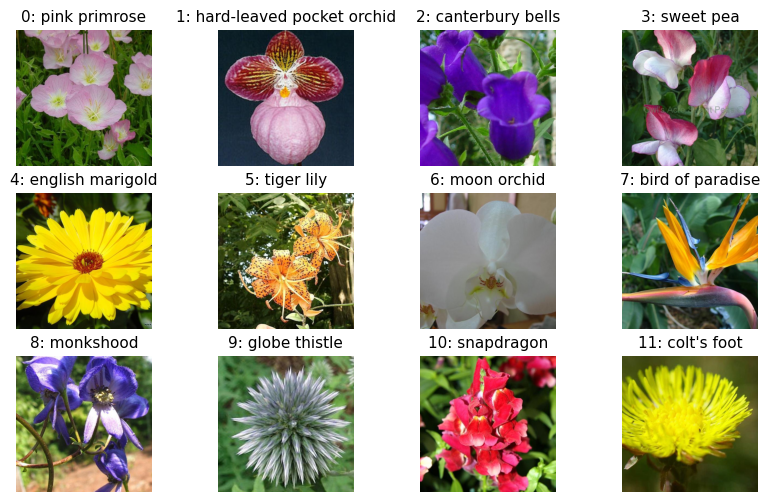

In [14]:
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(500),
])
flowers_to_display = DefaultFlowers102(split="train", transform=transform)
sample_flowers = sorted({y: img for img, y in flowers_to_display}.items())[:12]

def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    
plt.figure(figsize=(10, 6))
for class_id, image in sample_flowers:
    if class_id == 12: break
    plt.subplot(3, 4, class_id + 1)
    plot_image(image)
    plt.title(f"{class_id}: {class_names[class_id]}", fontsize=11)

plt.show()

In [15]:
[name for name, child in model.named_children()]

['features', 'avgpool', 'classifier']

In [16]:
model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)

In [17]:
n_classes = 102  # len(class_names) == 102
model.classifier[2] = nn.Linear(1024, n_classes).to(device)

Frys parametrarna i CNN lagren och aktivera dem i klassificeraren:

In [18]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [19]:
n_epochs = 5
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss().to(device)
accuracy = torchmetrics.Accuracy(task="multiclass",
                                 num_classes=102).to(device)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

torch.save(model.state_dict(), "flowers_epochs_5.pth")

Epoch 1/5, train loss: 4.3404, train metric: 0.1069, valid metric: 0.4324
Epoch 2/5, train loss: 3.2229, train metric: 0.5696, valid metric: 0.6157
Epoch 3/5, train loss: 2.3977, train metric: 0.7049, valid metric: 0.6990
Epoch 4/5, train loss: 1.7567, train metric: 0.8069, valid metric: 0.7343
Epoch 5/5, train loss: 1.3440, train metric: 0.8353, valid metric: 0.7627


In [20]:
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)
torch.save(model.state_dict(), "flowers_epochs_10.pth")

Epoch 1/5, train loss: 1.0469, train metric: 0.8765, valid metric: 0.7873
Epoch 2/5, train loss: 0.8255, train metric: 0.9020, valid metric: 0.8127
Epoch 3/5, train loss: 0.6846, train metric: 0.9069, valid metric: 0.8029
Epoch 4/5, train loss: 0.6055, train metric: 0.9343, valid metric: 0.8314
Epoch 5/5, train loss: 0.5053, train metric: 0.9490, valid metric: 0.8382


"Frys upp" de parametrarna i det sista lagret

In [21]:
*_, last = model.features.children()
for param in last.parameters():
    param.requires_grad = True

In [22]:
n_epochs = 3
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)
torch.save(model.state_dict(), "flowers_unfrozen_last_epochs_13.pth")

Epoch 1/3, train loss: 0.3516, train metric: 0.9304, valid metric: 0.8490
Epoch 2/3, train loss: 0.2070, train metric: 0.9647, valid metric: 0.8686
Epoch 3/3, train loss: 0.1757, train metric: 0.9735, valid metric: 0.8706


In [23]:
model.eval()
y_logits = []
y_labels = []
with torch.no_grad():
    for test, label in test_loader:
        y_logits += [model(test.to(device))]
        y_labels += [label]


In [24]:

y_preds = [torch.argmax(y_logit, dim=1) for y_logit in y_logits]

In [25]:
len(y_preds), len(y_labels)

(193, 193)

In [26]:
y_pred = []
y_label = []
for pred, label in zip(y_preds, y_labels):
    y_pred += pred.cpu()
    y_label += label


In [27]:
len(y_pred), len(y_label)

(6149, 6149)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_label, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.80      0.73        20
           1       1.00      0.93      0.96        40
           2       0.38      0.55      0.45        20
           3       0.58      0.61      0.59        36
           4       0.74      0.69      0.71        45
           5       1.00      0.92      0.96        25
           6       0.83      0.95      0.88        20
           7       0.98      0.98      0.98        65
           8       0.71      0.92      0.80        26
           9       0.96      1.00      0.98        25
          10       0.82      0.54      0.65        67
          11       0.94      0.93      0.93        67
          12       0.93      0.93      0.93        29
          13       0.93      1.00      0.97        28
          14       0.74      0.97      0.84        29
          15       0.57      0.95      0.71        21
          16       0.92      0.92      0.92        65
          17       0.62    

Blev det bättre än att bara fortsätta träna?

In [29]:
model.load_state_dict(torch.load("flowers_epochs_10.pth", weights_only=True))
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [30]:
n_epochs = 3
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)
torch.save(model.state_dict(), "flowers_epochs_13.pth")

Epoch 1/3, train loss: 0.4140, train metric: 0.9676, valid metric: 0.8402
Epoch 2/3, train loss: 0.3870, train metric: 0.9520, valid metric: 0.8333
Epoch 3/3, train loss: 0.3258, train metric: 0.9588, valid metric: 0.8363


In [31]:
model.eval()
y_logits = []
y_labels = []
with torch.no_grad():
    for test, label in test_loader:
        y_logits += [model(test.to(device))]
        y_labels += [label]

y_preds = [torch.argmax(y_logit, dim=1) for y_logit in y_logits]
y_pred = []
y_label = []
for pred, label in zip(y_preds, y_labels):
    y_pred += pred.cpu()
    y_label += label

print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.85      0.68        20
           1       1.00      0.90      0.95        40
           2       0.25      0.50      0.33        20
           3       0.45      0.50      0.47        36
           4       0.75      0.73      0.74        45
           5       1.00      0.88      0.94        25
           6       0.90      0.95      0.93        20
           7       0.98      1.00      0.99        65
           8       0.71      0.77      0.74        26
           9       0.89      0.96      0.92        25
          10       0.81      0.45      0.58        67
          11       0.90      0.82      0.86        67
          12       0.97      0.97      0.97        29
          13       0.93      1.00      0.97        28
          14       0.71      0.93      0.81        29
          15       0.77      0.95      0.85        21
          16       0.93      0.83      0.88        65
          17       0.59    

Det blev bättre! När det är dags att börja luckra upp lager är mest baserat på känsla. Jag har läst både att man aldrig skall göra det och att man gradvis skall gå djupare redan från början tills man inte ser mer förbättringar. Det är lätt att förstöra tidigare lager om man går för djupt eller för långt i träningen, så i praktiken verkar det vara någonstans i mitten. Det går förstås att sätta den tidpunkten som en hyperparameter och optimera på det också!

En tumregel är att bara luckra i de översta lagren när kurvorna börjar plana av och att då göra det i få epoker och spåra valideringsdatan för att undvika överanpassning. Men det finns gott om exempel som går mycket längre och får bra resultat-- däremot rapporteras knappast alla misslyckade försök med detsamma!

## Modeller i mängder

[https://keras.io/keras_hub/presets/](https://keras.io/keras_hub/presets/)

[Huggingface keras modeller](https://huggingface.co/models?library=keras&sort=trending)

[direkt integration keras-huggingface](https://huggingface.co/docs/hub/en/keras)

[Huggingface pytorch modeller](https://huggingface.co/models?library=pytorch&sort=trending)
